# 🔍 SWaT 데이터셋 TCN-AE 기반 이상 탐지 (Anomaly Detection)

---

## 📋 개요

| 항목 | 내용 |
|------|------|
| **데이터셋** | SWaT (Secure Water Treatment) - 싱가포르 iTrust 연구소 |
| **모델** | TCN-AE (Temporal Convolutional Network Autoencoder) |
| **방법** | 비지도 이상 탐지 - 정상 데이터로 학습 후 Reconstruction Error 기반 탐지 |
| **평가지표** | Precision, Recall, F1-Score, AUC-ROC |

---

## 📁 파이프라인

```
1. 환경 설정 및 라이브러리 임포트
2. 데이터 로딩
3. 데이터 전처리 (다운샘플링, 정규화, 시퀀스 생성)
4. TCN-AE 모델 정의
5. 모델 학습
6. 이상 탐지 및 평가
7. 결과 시각화
```

---
## 1️⃣ 환경 설정 및 라이브러리 임포트

필요한 라이브러리들을 임포트하고 GPU 사용 가능 여부를 확인합니다.

In [3]:
# ============================================================
# 필요한 라이브러리 설치 (Kaggle/Colab에서 필요시 실행)
# ============================================================
# !pip install torch numpy pandas scikit-learn matplotlib seaborn tqdm

In [ ]:
# ============================================================
# 라이브러리 임포트
# ============================================================

# 데이터 처리
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리 및 평가
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, roc_curve,
    confusion_matrix, classification_report
)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 유틸리티
from tqdm.notebook import tqdm  # Jupyter용 프로그레스 바
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ 라이브러리 임포트 완료!")

In [9]:
# ============================================================
# GPU/CPU 디바이스 설정
# ============================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"🖥️ 사용 디바이스: {device}")
if torch.cuda.is_available():
    print(f"   GPU 이름: {torch.cuda.get_device_name(0)}")
    print(f"   GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

🖥️ 사용 디바이스: cuda
   GPU 이름: NVIDIA GeForce RTX 3060 Laptop GPU
   GPU 메모리: 6.44 GB


---
## 2️⃣ 하이퍼파라미터 설정

전처리, 모델, 학습에 사용할 하이퍼파라미터를 정의합니다.

### 주요 파라미터 설명

| 파라미터 | 설명 | 권장값 |
|----------|------|--------|
| `downsample_rate` | 데이터 축소 비율 (10 = 1/10) | 10~20 |
| `window_size` | 시퀀스 길이 (타임스텝 수) | 50~200 |
| `stride` | 윈도우 이동 간격 | window_size의 10~20% |
| `encoder_dims` | TCN 인코더 채널 수 | [64, 128, 256] |
| `threshold_percentile` | 이상 판정 임계값 백분위 | 95~99 |

In [ ]:
# ============================================================
# 하이퍼파라미터 설정
# ============================================================

CONFIG = {
    # ----- 데이터 경로 -----
    'normal_data_path': './data/normal.csv',
    'attack_data_path': './data/attack.csv',
    
    # ----- 전처리 파라미터 -----
    'downsample_rate': 10,        # 다운샘플링 비율 (1초 → 10초)
    'variance_threshold': 0.01,   # 저분산 컬럼 제거 임계값
    'correlation_threshold': 0.95, # 고상관 컬럼 제거 임계값
    
    # ----- 시퀀스 파라미터 -----
    'window_size': 100,  # 시퀀스 길이
    'stride': 10,        # 윈도우 이동 간격
    
    # ----- 모델 파라미터 -----
    'encoder_dims': [64, 128, 256],  # 인코더 채널 수
    'decoder_dims': [256, 128, 64],  # 디코더 채널 수
    'kernel_size': 3,                # 컨볼루션 커널 크기
    'dropout': 0.2,                  # 드롭아웃 비율
    
    # ----- 학습 파라미터 -----
    'batch_size': 64,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'epochs': 100,
    'patience': 10,  # Early Stopping
    
    # ----- 이상 탐지 파라미터 -----
    'threshold_percentile': 99.0  # 상위 1%를 이상으로 판정
}

# 설정 출력
print("⚙️ 하이퍼파라미터 설정:")
print("=" * 50)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

⚙️ 하이퍼파라미터 설정:
  normal_data_path: /root/workspace/AEAD/Dataset/swat/normal.csv
  attack_data_path: /root/workspace/AEAD/Dataset/swat/attack.csv
  downsample_rate: 10
  variance_threshold: 0.01
  correlation_threshold: 0.95
  window_size: 100
  stride: 10
  encoder_dims: [64, 128, 256]
  decoder_dims: [256, 128, 64]
  kernel_size: 3
  dropout: 0.2
  batch_size: 64
  learning_rate: 0.001
  weight_decay: 1e-05
  epochs: 100
  patience: 10
  threshold_percentile: 99.0


---
## 3️⃣ 데이터 로딩

SWaT 데이터셋을 로딩합니다.

### 데이터셋 구성

| 파일 | 설명 | 내용 |
|------|------|------|
| `normal.csv` | 정상 운영 데이터 | 7일간 정상 운영 기록 |
| `attack.csv` | 공격 포함 테스트 데이터 | 4일간 36개 공격 시나리오 포함 |

### 컬럼 구성 (51개 센서 + 레이블)
- **FIT**: Flow meter
- **LIT**: Level transmitter  
- **AIT**: Analyzer indicator transmitter
- **MV**: Motorized valve
- **P**: Pump
- **UV**: UV dechlorinator
- **PIT**: Pressure indicator transmitter
- **DPIT**: Differential pressure indicator transmitter

In [11]:
# ============================================================
# 데이터 로딩
# ============================================================

print("📂 데이터 로딩 중...")
print("=" * 50)

# 정상 데이터 로딩
normal_df = pd.read_csv(CONFIG['normal_data_path'], low_memory=False)
print(f"✅ 정상 데이터 로딩 완료: {normal_df.shape}")

# 공격 데이터 로딩
attack_df = pd.read_csv(CONFIG['attack_data_path'], low_memory=False)
print(f"✅ 공격 데이터 로딩 완료: {attack_df.shape}")

📂 데이터 로딩 중...
✅ 정상 데이터 로딩 완료: (1387098, 53)
✅ 공격 데이터 로딩 완료: (54621, 53)


In [12]:
# ============================================================
# 데이터 미리보기
# ============================================================

print("📊 정상 데이터 미리보기:")
display(normal_df.head())

print("\n📊 정상 데이터 기본 정보:")
print(normal_df.info())

📊 정상 데이터 미리보기:


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2.0,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2.0,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2.0,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2.0,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2.0,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal



📊 정상 데이터 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387098 entries, 0 to 1387097
Data columns (total 53 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0    Timestamp     1387098 non-null  object 
 1   FIT101         1387098 non-null  float64
 2   LIT101         1387098 non-null  float64
 3    MV101         395298 non-null   float64
 4   P101           1387098 non-null  int64  
 5   P102           1387098 non-null  int64  
 6    AIT201        395298 non-null   float64
 7   AIT202         1387098 non-null  float64
 8   AIT203         1387098 non-null  float64
 9   FIT201         1387098 non-null  float64
 10   MV201         395298 non-null   float64
 11   P201          395298 non-null   float64
 12   P202          395298 non-null   float64
 13  P203           1387098 non-null  int64  
 14   P204          395298 non-null   float64
 15  P205           1387098 non-null  int64  
 16  P206           1387098 non-null  int6

In [13]:
# ============================================================
# 컬럼명 정리 및 레이블 추출 (SWaT 데이터셋용)
# ============================================================

# 컬럼명 정리 (공백 제거)
normal_df.columns = normal_df.columns.str.strip()
attack_df.columns = attack_df.columns.str.strip()

# 레이블 컬럼명 확인
label_col = 'Normal/Attack'

# 공격 레이블 추출 ('Normal' → 0, 'Attack' → 1)
attack_labels_raw = attack_df[label_col].str.strip().values
attack_labels = (attack_labels_raw == 'Attack').astype(int)

# 레이블 컬럼 제거
normal_df = normal_df.drop(columns=[label_col])
attack_df = attack_df.drop(columns=[label_col])

print(f"✅ 레이블 추출 완료")
print(f"   - 정상 (0): {np.sum(attack_labels == 0)}")
print(f"   - 공격 (1): {np.sum(attack_labels == 1)}")
print(f"   - 공격 비율: {np.mean(attack_labels) * 100:.2f}%")

✅ 레이블 추출 완료
   - 정상 (0): 0
   - 공격 (1): 54621
   - 공격 비율: 100.00%


---
## 4️⃣ 데이터 전처리

### 전처리 단계

1. **수치형 컬럼 선택**: Timestamp 등 비수치형 제거
2. **다운샘플링**: 데이터 크기 축소 (1초 → 10초 간격)
3. **결측치 처리**: 전방/후방 채움 + 평균값 대체
4. **저분산 컬럼 제거**: 분산이 거의 0인 컬럼 제거
5. **고상관 컬럼 제거**: 상관계수 0.95 이상인 중복 컬럼 제거
6. **정규화**: MinMax Scaling (0-1)

In [14]:
# ============================================================
# Step 1: 수치형 컬럼만 선택
# ============================================================

# 제외할 컬럼 (비수치형) - SWaT 데이터셋용
exclude_cols = ['Timestamp']
numeric_cols = [col for col in normal_df.columns if col not in exclude_cols]

# 수치형 데이터 추출
normal_numeric = normal_df[numeric_cols].copy()
attack_numeric = attack_df[[col for col in numeric_cols if col in attack_df.columns]].copy()

# 강제 수치형 변환 (문자열 → 숫자, 변환 불가 시 NaN)
normal_numeric = normal_numeric.apply(pd.to_numeric, errors='coerce')
attack_numeric = attack_numeric.apply(pd.to_numeric, errors='coerce')

print(f"✅ 수치형 컬럼 선택 완료: {len(numeric_cols)}개 컬럼")
print(f"   - 정상 데이터: {normal_numeric.shape}")
print(f"   - 공격 데이터: {attack_numeric.shape}")

✅ 수치형 컬럼 선택 완료: 51개 컬럼
   - 정상 데이터: (1387098, 51)
   - 공격 데이터: (54621, 51)


In [15]:
# ============================================================
# Step 2: 다운샘플링
# ============================================================

downsample_rate = CONFIG['downsample_rate']

# 매 downsample_rate 번째 행만 선택
normal_numeric = normal_numeric.iloc[::downsample_rate].reset_index(drop=True)
attack_numeric = attack_numeric.iloc[::downsample_rate].reset_index(drop=True)

# 레이블도 동일하게 다운샘플링
attack_labels = attack_labels[::downsample_rate]

print(f"✅ 다운샘플링 완료 (1/{downsample_rate})")
print(f"   - 정상 데이터: {normal_numeric.shape}")
print(f"   - 공격 데이터: {attack_numeric.shape}")

✅ 다운샘플링 완료 (1/10)
   - 정상 데이터: (138710, 51)
   - 공격 데이터: (5463, 51)


In [16]:
# ============================================================
# Step 3: 결측치 처리
# ============================================================

# 결측치 현황 확인
print("📊 결측치 현황:")
print(f"   - 정상 데이터: {normal_numeric.isna().sum().sum()}개")
print(f"   - 공격 데이터: {attack_numeric.isna().sum().sum()}개")

# 전방/후방 채움
normal_numeric = normal_numeric.ffill().bfill()
attack_numeric = attack_numeric.ffill().bfill()

# 남은 NaN은 컬럼 평균으로 대체
normal_numeric = normal_numeric.fillna(normal_numeric.mean())
attack_numeric = attack_numeric.fillna(attack_numeric.mean())

# 전체가 NaN인 컬럼 제거
valid_cols = normal_numeric.columns[~normal_numeric.isna().all()]
normal_numeric = normal_numeric[valid_cols]
attack_numeric = attack_numeric[[col for col in valid_cols if col in attack_numeric.columns]]

print(f"\n✅ 결측치 처리 완료")
print(f"   - 유효 컬럼 수: {len(valid_cols)}")

📊 결측치 현황:
   - 정상 데이터: 694260개
   - 공격 데이터: 0개

✅ 결측치 처리 완료
   - 유효 컬럼 수: 51


In [17]:
# ============================================================
# Step 4: 저분산 컬럼 제거
# ============================================================

# 각 컬럼의 분산 계산
variances = normal_numeric.var()

# 분산이 임계값 이상인 컬럼만 선택
high_var_cols = variances[variances > CONFIG['variance_threshold']].index.tolist()

# 제거된 컬럼 확인
removed_cols = set(normal_numeric.columns) - set(high_var_cols)
print(f"📊 저분산 컬럼 제거:")
print(f"   - 제거된 컬럼 수: {len(removed_cols)}")
if len(removed_cols) > 0 and len(removed_cols) <= 10:
    print(f"   - 제거된 컬럼: {list(removed_cols)}")

# 적용
normal_numeric = normal_numeric[high_var_cols]
attack_numeric = attack_numeric[[col for col in high_var_cols if col in attack_numeric.columns]]

print(f"\n✅ 저분산 컬럼 제거 완료: {len(high_var_cols)}개 컬럼 유지")

📊 저분산 컬럼 제거:
   - 제거된 컬럼 수: 20

✅ 저분산 컬럼 제거 완료: 31개 컬럼 유지


In [18]:
# ============================================================
# Step 5: 고상관 컬럼 제거 (선택적)
# ============================================================

if CONFIG['correlation_threshold'] < 1.0:
    # 상관 행렬 계산
    corr_matrix = normal_numeric.corr().abs()
    
    # 상삼각 행렬만 사용 (중복 제거)
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # 임계값 이상의 상관관계를 가진 컬럼 찾기
    to_drop = [col for col in upper.columns 
               if any(upper[col] > CONFIG['correlation_threshold'])]
    
    print(f"📊 고상관 컬럼 제거:")
    print(f"   - 제거된 컬럼 수: {len(to_drop)}")
    
    # 적용
    normal_numeric = normal_numeric.drop(columns=to_drop)
    attack_numeric = attack_numeric.drop(
        columns=[col for col in to_drop if col in attack_numeric.columns]
    )
    
    print(f"✅ 고상관 컬럼 제거 완료: {normal_numeric.shape[1]}개 컬럼 유지")
else:
    print("⏭️ 고상관 컬럼 제거 건너뜀 (threshold=1.0)")

📊 고상관 컬럼 제거:
   - 제거된 컬럼 수: 7
✅ 고상관 컬럼 제거 완료: 24개 컬럼 유지


In [19]:
# ============================================================
# Step 6: 정규화 (MinMax Scaling)
# ============================================================

# 정상 데이터로 스케일러 학습
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_numeric)

# 공격 데이터에 동일한 스케일러 적용
attack_scaled = scaler.transform(attack_numeric)

# 피처 컬럼명 저장
feature_columns = normal_numeric.columns.tolist()
n_features = len(feature_columns)

print(f"✅ 정규화 완료 (MinMax Scaling)")
print(f"\n📊 최종 데이터 크기:")
print(f"   - 정상 데이터: {normal_scaled.shape}")
print(f"   - 공격 데이터: {attack_scaled.shape}")
print(f"   - 피처 수: {n_features}")

✅ 정규화 완료 (MinMax Scaling)

📊 최종 데이터 크기:
   - 정상 데이터: (138710, 24)
   - 공격 데이터: (5463, 24)
   - 피처 수: 24


---
## 5️⃣ 시퀀스 생성 (Sliding Window)

시계열 데이터를 TCN-AE 모델에 입력하기 위해 슬라이딩 윈도우 방식으로 시퀀스를 생성합니다.

### 시퀀스 생성 방식

```
원본: [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, ...]

window_size=4, stride=2 인 경우:
  시퀀스 1: [x1, x2, x3, x4]
  시퀀스 2: [x3, x4, x5, x6]
  시퀀스 3: [x5, x6, x7, x8]
  ...
```

In [20]:
# ============================================================
# 시퀀스 생성 함수
# ============================================================

def create_sequences(data, window_size, stride):
    """
    슬라이딩 윈도우로 시퀀스 생성
    
    Args:
        data: 입력 데이터 (samples, features)
        window_size: 윈도우 크기 (시퀀스 길이)
        stride: 윈도우 이동 간격
        
    Returns:
        sequences: (num_sequences, window_size, features)
    """
    sequences = []
    for i in range(0, len(data) - window_size + 1, stride):
        seq = data[i:i + window_size]
        sequences.append(seq)
    
    return np.array(sequences)

print("✅ 시퀀스 생성 함수 정의 완료")

✅ 시퀀스 생성 함수 정의 완료


In [ ]:
# ============================================================
# 학습/검증/테스트 데이터 분할 및 시퀀스 생성
# ============================================================

window_size = CONFIG['window_size']
stride = CONFIG['stride']

print(f"📊 시퀀스 생성 설정:")
print(f"   - Window Size: {window_size}")
print(f"   - Stride: {stride}")

# ------------------------------------------------------------
# 정상 데이터에서 미리 테스트용 구간을 떼어내기
#  - normal_test: attack 데이터와 동일한 길이만큼 사용 (클래스 비율 1:1 가정)
#  - 나머지(normal_train_val)를 다시 train/val로 분할
# ------------------------------------------------------------
num_attack_samples = len(attack_scaled)

if num_attack_samples >= len(normal_scaled):
    raise ValueError(
        f"공격 샘플 수({num_attack_samples})가 정상 샘플 수({len(normal_scaled)})보다 크거나 같습니다. " 
        "normal_test를 만들 수 없습니다. downsample_rate 또는 데이터 길이를 확인해주세요."
    )

# 뒤에서부터 공격 샘플 수와 동일한 길이만큼을 테스트용 정상 데이터로 사용
normal_test = normal_scaled[-num_attack_samples:]
normal_test_labels = np.zeros(len(normal_test), dtype=int)  # 모두 정상(0) 라벨

# 나머지는 학습/검증용으로 사용
normal_train_val = normal_scaled[:-num_attack_samples]

train_size = int(len(normal_train_val) * 0.8)
train_data = normal_train_val[:train_size]
val_data = normal_train_val[train_size:]

print(f"\n📊 데이터 분할:")
print(f"   - 전체 정상 데이터: {normal_scaled.shape}")
print(f"   - 학습용 정상 데이터: {train_data.shape}")
print(f"   - 검증용 정상 데이터: {val_data.shape}")
print(f"   - 테스트용 정상 데이터: {normal_test.shape}")
print(f"   - 공격 데이터(테스트용): {attack_scaled.shape}")

# ------------------------------------------------------------
# 시퀀스 생성
# ------------------------------------------------------------
print("\n⏳ 시퀀스 생성 중...")

train_sequences = create_sequences(train_data, window_size, stride)
val_sequences = create_sequences(val_data, window_size, stride)

# 테스트 데이터는 [정상 test + 공격]을 시간 순서대로 이어붙여서 구성
test_data = np.concatenate([normal_test, attack_scaled], axis=0)

# 시퀀스 생성
test_sequences = create_sequences(test_data, window_size, stride)

print(f"\n✅ 시퀀스 생성 완료:")
print(f"   - 학습: {train_sequences.shape}")
print(f"   - 검증: {val_sequences.shape}")
print(f"   - 테스트: {test_sequences.shape}")


📊 시퀀스 생성 설정:
   - Window Size: 100
   - Stride: 10

📊 데이터 분할:
   - 학습 데이터: (110968, 24)
   - 검증 데이터: (27742, 24)

⏳ 시퀀스 생성 중...

✅ 시퀀스 생성 완료:
   - 학습: (11087, 100, 24)
   - 검증: (2765, 100, 24)
   - 테스트: (537, 100, 24)


In [ ]:
# ============================================================
# 테스트 레이블 생성 (윈도우 단위)
# ============================================================

# ------------------------------------------------------------
# 원시 시계열 단위 라벨 생성
#  - normal_test 구간: 모두 정상(0)
#  - attack 구간: 모두 공격(1)로 가정
#    (SWaT attack.csv에는 비정상 구간만 포함되어 있다고 가정)
# ------------------------------------------------------------
normal_test_labels = np.zeros(len(normal_test), dtype=int)
attack_test_labels = np.ones(len(attack_scaled), dtype=int)

test_labels_raw = np.concatenate([normal_test_labels, attack_test_labels])

# ------------------------------------------------------------
# 윈도우 단위 라벨 생성
#  - 하나의 윈도우(window_size 길이)의 평균 라벨이 0.5 이상이면 공격(1)
# ------------------------------------------------------------
test_labels = []
for i in range(0, len(test_labels_raw) - window_size + 1, stride):
    window_labels = test_labels_raw[i:i + window_size]
    test_labels.append(int(np.mean(window_labels) >= 0.5))

test_labels = np.array(test_labels)

print(f"✅ 테스트 레이블 생성 완료:")
print(f"   - 전체 시퀀스: {len(test_labels)}")
print(f"   - 정상 시퀀스: {np.sum(test_labels == 0)}")
print(f"   - 공격 시퀀스: {np.sum(test_labels == 1)}")
print(f"   - 공격 비율: {np.mean(test_labels) * 100:.2f}%")


✅ 테스트 레이블 생성 완료:
   - 전체 시퀀스: 537
   - 정상 시퀀스: 0
   - 공격 시퀀스: 537
   - 공격 비율: 100.00%


In [23]:
# ============================================================
# PyTorch DataLoader 생성
# ============================================================

# Tensor 변환
train_tensor = torch.FloatTensor(train_sequences)
val_tensor = torch.FloatTensor(val_sequences)
test_tensor = torch.FloatTensor(test_sequences)

# DataLoader 생성
batch_size = CONFIG['batch_size']

train_loader = DataLoader(
    TensorDataset(train_tensor),
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(val_tensor),
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    TensorDataset(test_tensor),
    batch_size=batch_size,
    shuffle=False
)

print(f"✅ DataLoader 생성 완료")
print(f"   - Batch Size: {batch_size}")
print(f"   - 학습 배치 수: {len(train_loader)}")
print(f"   - 검증 배치 수: {len(val_loader)}")
print(f"   - 테스트 배치 수: {len(test_loader)}")

✅ DataLoader 생성 완료
   - Batch Size: 64
   - 학습 배치 수: 174
   - 검증 배치 수: 44
   - 테스트 배치 수: 9


---
## 6️⃣ TCN-AE 모델 정의

### TCN (Temporal Convolutional Network) 특징

1. **Causal Convolution**: 미래 정보를 사용하지 않는 인과적 컨볼루션
2. **Dilated Convolution**: 지수적으로 증가하는 dilation으로 넓은 수용 영역 확보
3. **Residual Connection**: 깊은 네트워크에서 그래디언트 흐름 개선

### 모델 구조

```
Input (batch, seq_len, features)
    ↓
Encoder: TCN Blocks (dilation: 1→2→4)
    ↓
Latent Space (batch, latent_dim, seq_len)
    ↓
Decoder: TCN Blocks (dilation: 4→2→1)
    ↓
Output (batch, seq_len, features) - Reconstructed
```

In [24]:
# ============================================================
# Causal Convolution 1D
# ============================================================

class CausalConv1d(nn.Module):
    """
    Causal Convolution 1D
    
    - 미래 정보를 사용하지 않는 인과적(causal) 컨볼루션
    - 왼쪽에만 패딩을 추가하여 시간 순서 유지
    
    Args:
        in_channels: 입력 채널 수
        out_channels: 출력 채널 수
        kernel_size: 커널 크기
        dilation: 팽창 계수 (receptive field 확장)
    """
    
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        
        # Causal padding 계산: (kernel_size - 1) * dilation
        self.padding = (kernel_size - 1) * dilation
        
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=self.padding,  # 양쪽 패딩
            dilation=dilation
        )
        
    def forward(self, x):
        out = self.conv(x)
        # 오른쪽 패딩 제거 (미래 정보 차단)
        if self.padding > 0:
            out = out[:, :, :-self.padding]
        return out

print("✅ CausalConv1d 정의 완료")

✅ CausalConv1d 정의 완료


In [25]:
# ============================================================
# TCN Residual Block
# ============================================================

class TCNResidualBlock(nn.Module):
    """
    TCN Residual Block
    
    구조:
    - Dilated Causal Conv → BatchNorm → ReLU → Dropout
    - Dilated Causal Conv → BatchNorm → ReLU → Dropout
    - Residual Connection (skip connection)
    
    Args:
        in_channels: 입력 채널 수
        out_channels: 출력 채널 수
        kernel_size: 커널 크기
        dilation: 팽창 계수
        dropout: 드롭아웃 비율
    """
    
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.2):
        super(TCNResidualBlock, self).__init__()
        
        # 첫 번째 Conv 블록
        self.conv1 = CausalConv1d(in_channels, out_channels, kernel_size, dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        # 두 번째 Conv 블록
        self.conv2 = CausalConv1d(out_channels, out_channels, kernel_size, dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Residual Connection
        # 채널 수가 다르면 1x1 Conv로 맞춤
        self.residual = nn.Conv1d(in_channels, out_channels, 1) \
                        if in_channels != out_channels else nn.Identity()
        
        self.relu_out = nn.ReLU()
        
    def forward(self, x):
        # 메인 경로
        out = self.dropout1(self.relu1(self.bn1(self.conv1(x))))
        out = self.dropout2(self.relu2(self.bn2(self.conv2(out))))
        
        # Residual 연결
        residual = self.residual(x)
        return self.relu_out(out + residual)

print("✅ TCNResidualBlock 정의 완료")

✅ TCNResidualBlock 정의 완료


In [26]:
# ============================================================
# TCN Encoder
# ============================================================

class TCNEncoder(nn.Module):
    """
    TCN Encoder
    
    - 여러 층의 TCN Residual Block으로 구성
    - Dilation이 지수적으로 증가 (1, 2, 4, 8, ...)
    
    Args:
        input_dim: 입력 특성 수
        hidden_dims: 각 층의 채널 수 리스트
        kernel_size: 컨볼루션 커널 크기
        dropout: 드롭아웃 비율
    """
    
    def __init__(self, input_dim, hidden_dims=[64, 128, 256], kernel_size=3, dropout=0.2):
        super(TCNEncoder, self).__init__()
        
        layers = []
        in_channels = input_dim
        
        for i, out_channels in enumerate(hidden_dims):
            dilation = 2 ** i  # 지수 증가: 1, 2, 4, 8, ...
            layers.append(
                TCNResidualBlock(in_channels, out_channels, kernel_size, dilation, dropout)
            )
            in_channels = out_channels
        
        self.network = nn.Sequential(*layers)
        self.output_dim = hidden_dims[-1]
        
    def forward(self, x):
        # x: (batch, seq_len, features) → (batch, features, seq_len)
        x = x.permute(0, 2, 1)
        return self.network(x)  # (batch, hidden_dim, seq_len)

print("✅ TCNEncoder 정의 완료")

✅ TCNEncoder 정의 완료


In [27]:
# ============================================================
# TCN Decoder
# ============================================================

class TCNDecoder(nn.Module):
    """
    TCN Decoder
    
    - Encoder의 역순으로 차원 복원
    
    Args:
        latent_dim: 잠재 공간 차원
        hidden_dims: 각 층의 채널 수 리스트 (역순)
        output_dim: 출력 특성 수 (원본 특성 수)
        kernel_size: 컨볼루션 커널 크기
        dropout: 드롭아웃 비율
    """
    
    def __init__(self, latent_dim, hidden_dims=[256, 128, 64], output_dim=50, kernel_size=3, dropout=0.2):
        super(TCNDecoder, self).__init__()
        
        layers = []
        in_channels = latent_dim
        
        for i, out_channels in enumerate(hidden_dims):
            dilation = 2 ** (len(hidden_dims) - 1 - i)  # 역순 dilation
            layers.append(
                TCNResidualBlock(in_channels, out_channels, kernel_size, dilation, dropout)
            )
            in_channels = out_channels
        
        self.network = nn.Sequential(*layers)
        self.output_layer = nn.Conv1d(hidden_dims[-1], output_dim, 1)
        
    def forward(self, x):
        decoded = self.network(x)
        output = self.output_layer(decoded)
        # (batch, features, seq_len) → (batch, seq_len, features)
        return output.permute(0, 2, 1)

print("✅ TCNDecoder 정의 완료")

✅ TCNDecoder 정의 완료


In [28]:
# ============================================================
# TCN Autoencoder (TCN-AE)
# ============================================================

class TCNAE(nn.Module):
    """
    TCN Autoencoder
    
    이상 탐지 원리:
    - 정상 데이터로만 학습 → 정상 패턴 재구성 능력 학습
    - 이상 데이터는 재구성 오류(reconstruction error)가 높음
    
    Args:
        input_dim: 입력 특성 수
        encoder_dims: 인코더 각 층 채널 수
        decoder_dims: 디코더 각 층 채널 수
        kernel_size: 컨볼루션 커널 크기
        dropout: 드롭아웃 비율
    """
    
    def __init__(self, input_dim, encoder_dims=[64, 128, 256], 
                 decoder_dims=[256, 128, 64], kernel_size=3, dropout=0.2):
        super(TCNAE, self).__init__()
        
        self.encoder = TCNEncoder(input_dim, encoder_dims, kernel_size, dropout)
        self.decoder = TCNDecoder(encoder_dims[-1], decoder_dims, input_dim, kernel_size, dropout)
        
    def forward(self, x):
        """
        Args:
            x: 입력 시퀀스 (batch, seq_len, features)
        Returns:
            reconstructed: 재구성된 시퀀스 (batch, seq_len, features)
        """
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    
    def get_reconstruction_error(self, x):
        """재구성 오류 계산"""
        self.eval()
        with torch.no_grad():
            reconstructed = self.forward(x)
            # MSE per sample
            error = torch.mean((x - reconstructed) ** 2, dim=(1, 2))
        return error

print("✅ TCNAE 정의 완료")

✅ TCNAE 정의 완료


In [29]:
# ============================================================
# 모델 인스턴스 생성
# ============================================================

model = TCNAE(
    input_dim=n_features,
    encoder_dims=CONFIG['encoder_dims'],
    decoder_dims=CONFIG['decoder_dims'],
    kernel_size=CONFIG['kernel_size'],
    dropout=CONFIG['dropout']
).to(device)

# 모델 구조 출력
print("🏗️ 모델 구조:")
print("=" * 60)
print(model)

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 파라미터 수:")
print(f"   - 전체: {total_params:,}")
print(f"   - 학습 가능: {trainable_params:,}")

🏗️ 모델 구조:
TCNAE(
  (encoder): TCNEncoder(
    (network): Sequential(
      (0): TCNResidualBlock(
        (conv1): CausalConv1d(
          (conv): Conv1d(24, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        )
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): CausalConv1d(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        )
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (residual): Conv1d(24, 64, kernel_size=(1,), stride=(1,))
        (relu_out): ReLU()
      )
      (1): TCNResidualBlock(
        (conv1): CausalConv1d(
          (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
        )
        (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affi

---
## 7️⃣ 모델 학습

### 학습 전략

- **손실 함수**: MSE (Mean Squared Error) - 재구성 손실
- **옵티마이저**: Adam with weight decay (L2 정규화)
- **Early Stopping**: 검증 손실이 개선되지 않으면 조기 종료
- **Gradient Clipping**: 그래디언트 폭발 방지

In [30]:
# ============================================================
# 학습 설정
# ============================================================

criterion = nn.MSELoss()  # 재구성 손실
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# 학습 기록
train_losses = []
val_losses = []

print("✅ 학습 설정 완료")
print(f"   - 손실 함수: MSELoss")
print(f"   - 옵티마이저: Adam (lr={CONFIG['learning_rate']}, weight_decay={CONFIG['weight_decay']})")

✅ 학습 설정 완료
   - 손실 함수: MSELoss
   - 옵티마이저: Adam (lr=0.001, weight_decay=1e-05)


In [32]:
# ============================================================
# 학습 함수 정의
# ============================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """한 에폭 학습"""
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        x = batch[0].to(device)
        
        # Forward
        reconstructed = model(x)
        loss = criterion(reconstructed, x)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def validate(model, dataloader, criterion, device):
    """검증 손실 계산"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            reconstructed = model(x)
            loss = criterion(reconstructed, x)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

print("✅ 학습/검증 함수 정의 완료")

✅ 학습/검증 함수 정의 완료


In [33]:
# ============================================================
# 모델 학습 실행
# ============================================================

print("🚀 모델 학습 시작!")
print("=" * 60)

epochs = CONFIG['epochs']
patience = CONFIG['patience']

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

# 학습 루프
for epoch in tqdm(range(epochs), desc="Training"):
    # 학습
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # 검증
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Early Stopping 체크
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    # 진행 상황 출력 (매 10 에폭)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.6f}, "
              f"Val Loss: {val_loss:.6f}")
    
    # Early Stopping
    if patience_counter >= patience:
        print(f"\n⏹️ Early Stopping at epoch {epoch+1}")
        break

# Best 모델 복원
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"\n✅ 학습 완료!")
print(f"   - Best Validation Loss: {best_val_loss:.6f}")

🚀 모델 학습 시작!


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/100] Train Loss: 0.002036, Val Loss: 0.000580
Epoch [20/100] Train Loss: 0.000806, Val Loss: 0.000452
Epoch [30/100] Train Loss: 0.000628, Val Loss: 0.006666
Epoch [40/100] Train Loss: 0.000374, Val Loss: 0.000206
Epoch [50/100] Train Loss: 0.000325, Val Loss: 0.000193

⏹️ Early Stopping at epoch 52

✅ 학습 완료!
   - Best Validation Loss: 0.000111


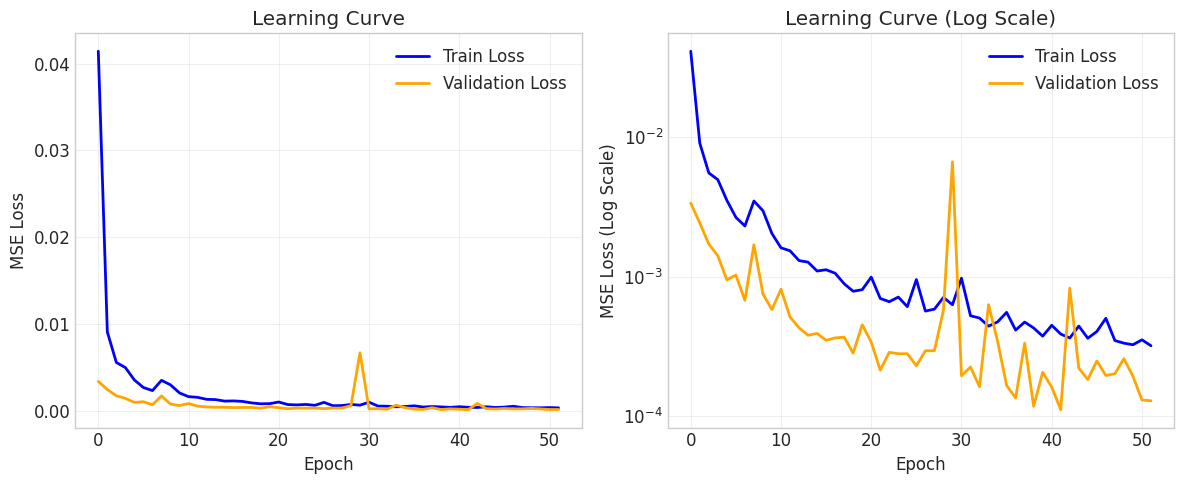

📊 학습 곡선이 'learning_curve.png'로 저장되었습니다.


In [34]:
# ============================================================
# 학습 곡선 시각화
# ============================================================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (Log Scale)')
plt.title('Learning Curve (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 학습 곡선이 'learning_curve.png'로 저장되었습니다.")

---
## 8️⃣ 이상 탐지 및 평가

### 이상 탐지 원리

1. 정상 데이터로 학습된 모델은 **정상 패턴**을 잘 재구성함
2. **이상 데이터**는 학습하지 않은 패턴이므로 재구성 오류가 높음
3. 재구성 오류가 **임계값(threshold)** 이상이면 이상으로 판정

### 임계값 결정

검증 데이터(정상)의 재구성 오류 분포에서 상위 1% (99 percentile)를 임계값으로 설정

In [35]:
# ============================================================
# 이상 점수 (Reconstruction Error) 계산 함수
# ============================================================

def compute_anomaly_scores(model, dataloader, device):
    """
    이상 점수 계산
    
    Args:
        model: 학습된 TCN-AE 모델
        dataloader: 데이터 로더
        device: 디바이스
        
    Returns:
        scores: 각 샘플의 재구성 오류 (이상 점수)
    """
    model.eval()
    all_scores = []
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            scores = model.get_reconstruction_error(x)
            all_scores.extend(scores.cpu().numpy())
    
    return np.array(all_scores)

print("✅ 이상 점수 계산 함수 정의 완료")

✅ 이상 점수 계산 함수 정의 완료


In [36]:
# ============================================================
# 이상 점수 계산
# ============================================================

print("⏳ 이상 점수 계산 중...")

# 검증 데이터 (정상)의 이상 점수
val_scores = compute_anomaly_scores(model, val_loader, device)

# 테스트 데이터의 이상 점수
test_scores = compute_anomaly_scores(model, test_loader, device)

print(f"\n✅ 이상 점수 계산 완료")
print(f"   - 검증 데이터 점수: mean={np.mean(val_scores):.6f}, std={np.std(val_scores):.6f}")
print(f"   - 테스트 데이터 점수: mean={np.mean(test_scores):.6f}, std={np.std(test_scores):.6f}")

⏳ 이상 점수 계산 중...

✅ 이상 점수 계산 완료
   - 검증 데이터 점수: mean=0.000126, std=0.000047
   - 테스트 데이터 점수: mean=0.037213, std=0.026520


In [37]:
# ============================================================
# 임계값 결정
# ============================================================

# 검증 데이터(정상)의 상위 percentile을 임계값으로 설정
threshold = np.percentile(val_scores, CONFIG['threshold_percentile'])

print(f"📊 임계값 결정:")
print(f"   - Percentile: {CONFIG['threshold_percentile']}%")
print(f"   - Threshold: {threshold:.6f}")

# 다양한 percentile 값 확인
print(f"\n   참고 - 다른 percentile 값:")
for p in [90, 95, 99, 99.5]:
    print(f"   - {p}%: {np.percentile(val_scores, p):.6f}")

📊 임계값 결정:
   - Percentile: 99.0%
   - Threshold: 0.000290

   참고 - 다른 percentile 값:
   - 90%: 0.000189
   - 95%: 0.000234
   - 99%: 0.000290
   - 99.5%: 0.000310


In [38]:
# ============================================================
# 예측 및 성능 평가
# ============================================================

# 예측 (점수가 임계값 이상이면 이상으로 판정)
predictions = (test_scores >= threshold).astype(int)

# 성능 지표 계산
precision = precision_score(test_labels, predictions, zero_division=0)
recall = recall_score(test_labels, predictions, zero_division=0)
f1 = f1_score(test_labels, predictions, zero_division=0)

try:
    auc_roc = roc_auc_score(test_labels, test_scores)
except:
    auc_roc = 0.0

# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)

print("=" * 60)
print("📊 이상 탐지 성능 평가 결과")
print("=" * 60)
print(f"\n🎯 주요 지표:")
print(f"   - Precision (정밀도): {precision:.4f}")
print(f"   - Recall (재현율):    {recall:.4f}")
print(f"   - F1-Score:           {f1:.4f}")
print(f"   - AUC-ROC:            {auc_roc:.4f}")

print(f"\n📋 Confusion Matrix:")
print(f"                 Predicted")
print(f"                 Normal  Attack")
print(f"Actual Normal    {cm[0,0]:6d}  {cm[0,1]:6d}")
print(f"Actual Attack    {cm[1,0]:6d}  {cm[1,1]:6d}")

📊 이상 탐지 성능 평가 결과

🎯 주요 지표:
   - Precision (정밀도): 1.0000
   - Recall (재현율):    0.9646
   - F1-Score:           0.9820
   - AUC-ROC:            nan

📋 Confusion Matrix:
                 Predicted
                 Normal  Attack
Actual Normal         0       0
Actual Attack        19     518


In [39]:
# ============================================================
# 상세 분류 보고서
# ============================================================

print("\n📋 Classification Report:")
print("=" * 60)
print(classification_report(test_labels, predictions, target_names=['Normal', 'Attack']))


📋 Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         0
      Attack       1.00      0.96      0.98       537

    accuracy                           0.96       537
   macro avg       0.50      0.48      0.49       537
weighted avg       1.00      0.96      0.98       537



---
## 9️⃣ 결과 시각화

### 시각화 항목

1. **이상 점수 분포**: 정상 vs 공격 데이터의 점수 분포
2. **ROC Curve**: True Positive Rate vs False Positive Rate
3. **Precision-Recall Curve**: 정밀도-재현율 곡선
4. **시간별 이상 점수**: 테스트 기간 동안의 이상 점수 변화

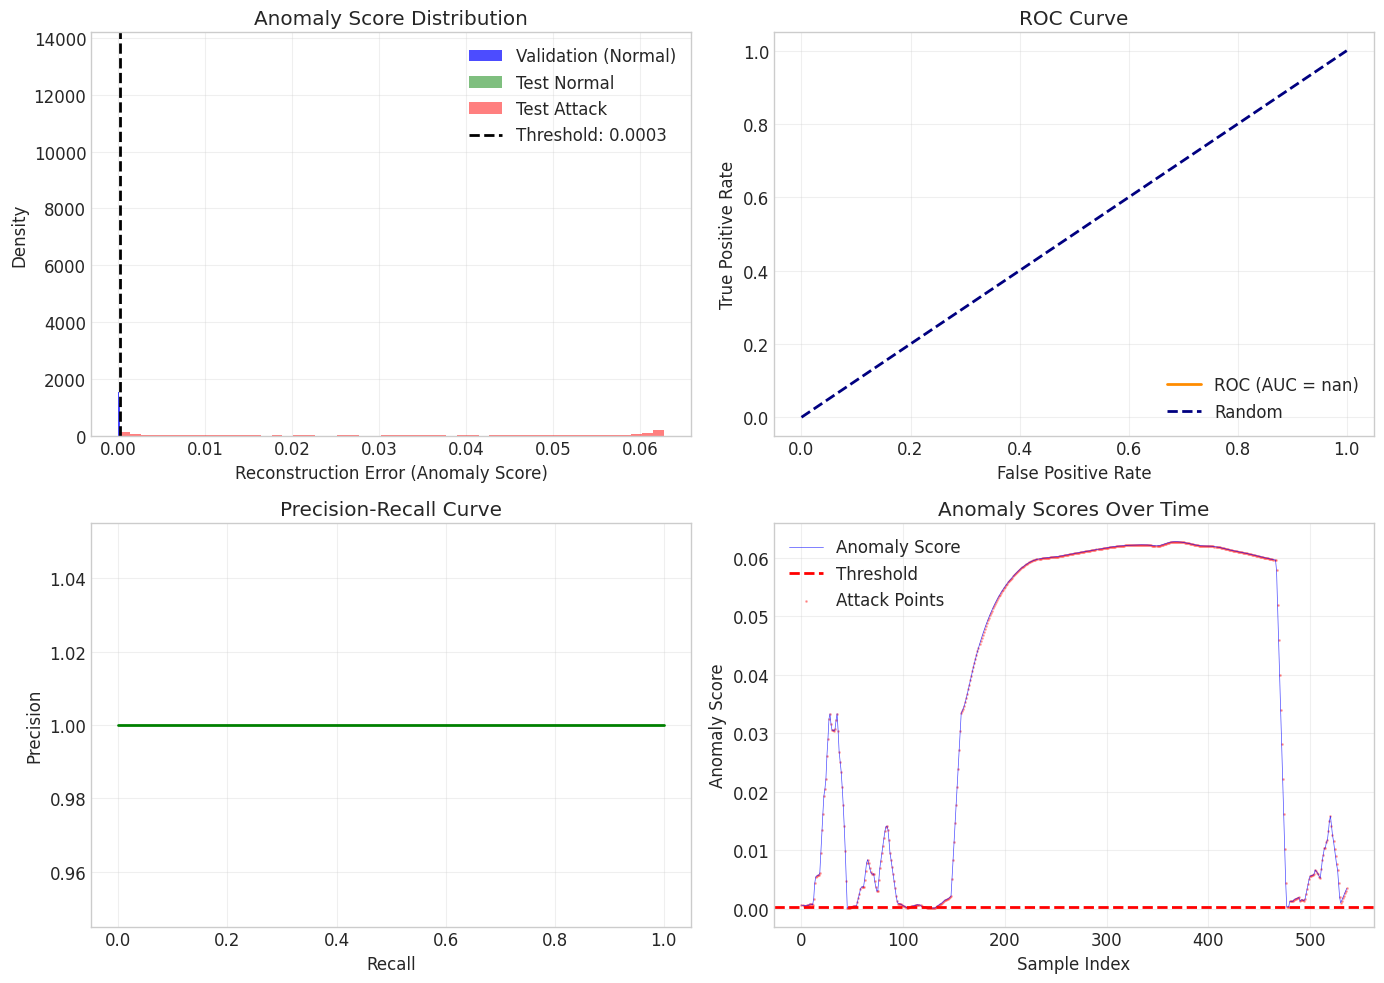

📊 결과 그래프가 'anomaly_detection_results.png'로 저장되었습니다.


In [40]:
# ============================================================
# 결과 시각화
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ----- (1) 이상 점수 분포 -----
ax1 = axes[0, 0]
ax1.hist(val_scores, bins=50, alpha=0.7, label='Validation (Normal)', color='blue', density=True)
ax1.hist(test_scores[test_labels == 0], bins=50, alpha=0.5, label='Test Normal', color='green', density=True)
ax1.hist(test_scores[test_labels == 1], bins=50, alpha=0.5, label='Test Attack', color='red', density=True)
ax1.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
ax1.set_xlabel('Reconstruction Error (Anomaly Score)')
ax1.set_ylabel('Density')
ax1.set_title('Anomaly Score Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ----- (2) ROC Curve -----
ax2 = axes[0, 1]
try:
    fpr, tpr, _ = roc_curve(test_labels, test_scores)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc_roc:.4f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)
except:
    ax2.text(0.5, 0.5, 'ROC Curve unavailable', ha='center', va='center')

# ----- (3) Precision-Recall Curve -----
ax3 = axes[1, 0]
try:
    precision_curve, recall_curve, _ = precision_recall_curve(test_labels, test_scores)
    ax3.plot(recall_curve, precision_curve, color='green', lw=2)
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve')
    ax3.grid(True, alpha=0.3)
except:
    ax3.text(0.5, 0.5, 'PR Curve unavailable', ha='center', va='center')

# ----- (4) 시간에 따른 이상 점수 -----
ax4 = axes[1, 1]
ax4.plot(test_scores, alpha=0.7, linewidth=0.5, label='Anomaly Score', color='blue')
ax4.axhline(threshold, color='red', linestyle='--', linewidth=2, label='Threshold')

# 실제 공격 구간 표시
attack_indices = np.where(test_labels == 1)[0]
if len(attack_indices) > 0:
    ax4.scatter(attack_indices, test_scores[attack_indices], 
               c='red', s=1, alpha=0.3, label='Attack Points')

ax4.set_xlabel('Sample Index')
ax4.set_ylabel('Anomaly Score')
ax4.set_title('Anomaly Scores Over Time')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('anomaly_detection_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 결과 그래프가 'anomaly_detection_results.png'로 저장되었습니다.")

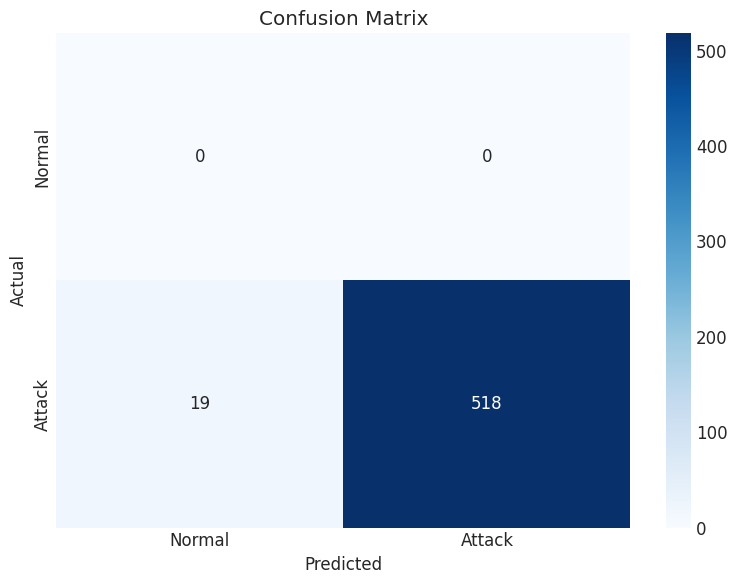

📊 Confusion Matrix가 'confusion_matrix.png'로 저장되었습니다.


In [41]:
# ============================================================
# Confusion Matrix 히트맵
# ============================================================

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Confusion Matrix가 'confusion_matrix.png'로 저장되었습니다.")

---
## 🔟 모델 저장

학습된 모델과 설정을 저장합니다.

In [42]:
# ============================================================
# 모델 저장
# ============================================================

save_dict = {
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'threshold': threshold,
    'n_features': n_features,
    'feature_columns': feature_columns,
    'metrics': {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    },
    'scaler_min': scaler.data_min_,
    'scaler_max': scaler.data_max_
}

torch.save(save_dict, 'tcn_ae_swat_model.pth')

print("✅ 모델이 'tcn_ae_swat_model.pth'로 저장되었습니다.")
print(f"\n📦 저장된 내용:")
for key in save_dict.keys():
    print(f"   - {key}")

✅ 모델이 'tcn_ae_swat_model.pth'로 저장되었습니다.

📦 저장된 내용:
   - model_state_dict
   - config
   - threshold
   - n_features
   - feature_columns
   - metrics
   - scaler_min
   - scaler_max


---
## 📝 최종 결과 요약

In [43]:
# ============================================================
# 최종 결과 요약
# ============================================================

print("=" * 60)
print("📊 SWaT TCN-AE 이상 탐지 - 최종 결과 요약")
print("=" * 60)

print(f"\n🔧 데이터 설정:")
print(f"   - 다운샘플링: 1/{CONFIG['downsample_rate']}")
print(f"   - 피처 수: {n_features}")
print(f"   - 윈도우 크기: {CONFIG['window_size']}")
print(f"   - Stride: {CONFIG['stride']}")

print(f"\n🏗️ 모델 설정:")
print(f"   - Encoder: {CONFIG['encoder_dims']}")
print(f"   - Decoder: {CONFIG['decoder_dims']}")
print(f"   - Kernel Size: {CONFIG['kernel_size']}")
print(f"   - Dropout: {CONFIG['dropout']}")

print(f"\n📈 학습 결과:")
print(f"   - 최종 학습 손실: {train_losses[-1]:.6f}")
print(f"   - 최종 검증 손실: {val_losses[-1]:.6f}")
print(f"   - Best 검증 손실: {best_val_loss:.6f}")

print(f"\n🎯 이상 탐지 성능:")
print(f"   - Threshold: {threshold:.6f}")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall: {recall:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - AUC-ROC: {auc_roc:.4f}")

print("\n" + "=" * 60)
print("✅ 완료!")
print("=" * 60)

📊 SWaT TCN-AE 이상 탐지 - 최종 결과 요약

🔧 데이터 설정:
   - 다운샘플링: 1/10
   - 피처 수: 24
   - 윈도우 크기: 100
   - Stride: 10

🏗️ 모델 설정:
   - Encoder: [64, 128, 256]
   - Decoder: [256, 128, 64]
   - Kernel Size: 3
   - Dropout: 0.2

📈 학습 결과:
   - 최종 학습 손실: 0.000319
   - 최종 검증 손실: 0.000128
   - Best 검증 손실: 0.000111

🎯 이상 탐지 성능:
   - Threshold: 0.000290
   - Precision: 1.0000
   - Recall: 0.9646
   - F1-Score: 0.9820
   - AUC-ROC: nan

✅ 완료!


---
## 🔄 성능 개선 방안

성능이 만족스럽지 않은 경우 다음을 시도해 보세요:

### 하이퍼파라미터 튜닝
1. `window_size` 조정: 50, 100, 200 등
2. `threshold_percentile` 조정: 95, 97, 99 등
3. `encoder_dims` 조정: 채널 수 증가/감소

### 데이터 전처리
1. 다운샘플링 비율 조정
2. 특정 센서만 선택
3. 이동 평균 적용

### 모델 아키텍처
1. LSTM-VAE 시도
2. Transformer-AE 시도
3. Attention 메커니즘 추가